In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import imageio
import os
import csv
import torch.optim as optim
import torch.nn as nn
import collections
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import datetime

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

100%|██████████| 170498071/170498071 [00:01<00:00, 86612306.07it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


# 8장 - 컨볼루션을 활용한 일반화

In [2]:
# 7장 모델은 새나 비행기의 특성을 일반화하여 훈련하기보단 훈련셋을 암기하는 성향 보임
# 아키텍처 보면서 왜 이런 상황이 발생하는지 추측했는데, 완전 연결로 설정하면 이미지 안의 모든 가능한 위치 발견해야 돼서 파라미터가 너무 많아졌고(모델이 훈련셋 암기하기 쉬워짐) 위치에 독립적이지 못함(일반화가 힘듦)
# 신경망에서 완전 연결된 아핀 변환 유닛을 또 다른 선형 연산인 컨볼루션으로 바꿀 것임

## 1절 - 컨볼루션

In [3]:
# 컨볼루션 이해하고 신경망에서 어떻게 사용할지 배울 것임
# 컨볼루션이 어떻게 인접한 정보를 사용하고 위치 변화에 대한 불변성을 획득하는지를 먼저 배움
# 컨볼루션 정의하는 공식 확인하고, 펜과 종이를 사용해서 적용할 것

In [4]:
# 앞에서 nn.Linear 사용해 입력 이미지를 1차원으로 생각하고 n_output_features * n_input_features라는 가중치 행렬 곱함 -> 이미지의 각 채널은 가중치 집합과 곱해진 모든 픽셀의 총합을 각각의 출력 피처에 대해 계산

In [5]:
# 하늘을 나는 비행기같은 물체와 일치하는 패턴 인지하려면 인근 픽셀의 배열 방식을 살펴봐야 하며, 먼 픽셀에는 관심 끈다
# 수학적인 형태로 바꾸려면 이미지 내의 바로 옆 픽셀에 대한 가중치의 합을 계산하면 됨
# 출력 피처와 출력 픽셀 위치마다 가중치 행렬을 만드는 것(일정 거리 이상 떨어진 경우 가중치 0이라 생각)
# 계산 결과는 여전히 가중치의 합이므로 선형 연산으로 볼 수 있음

In [6]:
# 평행이동 불변성을 7장처럼 벡터 행렬로 효과 내려면 복잡한 가중치 패턴 구현해야 함
# 가중치 행렬의 대부분은 0(출력 픽셀로부터 멀리 있는 입력 픽셀도 영향 줄 수 있게 함), 입력에 대해 상대적으로 같은 위치에 있는 엔트리가 출력 픽셀에 동일한 영향 줄 방법 찾아야 함
# 다시 말해, 같은 값으로 초기화해야 하며 그래서 이 경우와 관련된 가중치가 훈련을 통해 업데이트시 영향 받지 않아야 함
# 이런 식으로 지역 패턴에 대응하여 가중치는 반응하고, 해당 패턴이 이미지의 어디에 존재하든 파악 가능

In [7]:
# 위 방법은 실행 가능하며 이미지에 대해 지역적인 평행이동 불변성을 보장하는 선형 연산도 존재 -> 컨볼루션(convolution)

In [8]:
# 이산 컨볼루션(discrete convolution)은 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것으로 정의
# 가중치 행렬은 커널(kernel)이라 부르며 입력의 모든 이웃에 대해 수행

In [9]:
# 2차원 텐서인 3*3커널과 1채널의 M*N 이미지 있다고 가정
"""
weight = torch.tensor([[w00, w01, w02],
                       [w10, w11, w12],
                       [w20, w21, w22]])
image = torch.tensor([[i00, i01, ..., i0N],
                      [...],
                      [iM0, iM1, ..., iMN]])
"""

'\nweight = torch.tensor([[w00, w01, w02],\n                       [w10, w11, w12],\n                       [w20, w21, w22]])\nimage = torch.tensor([[i00, i01, ..., i0N],\n                      [...],\n                      [iM0, iM1, ..., iMN]])\n'

In [10]:
# 편향값 없는 출력 이미지의 각 요소 계산은 다음과 같음
"""
011 = i11 * w00 + i12 * w01 + i13 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
"""

'\n011 = i11 * w00 + i12 * w01 + i13 * w02 +\n      i21 * w10 + i22 * w11 + i23 * w12 +\n      i31 * w20 + i32 * w21 + i33 * w22\n'

In [11]:
# 커널을 입력 이미지의 i11으로 평행이동햇고 이 위치의 입력 이미지 값과 가중치를 곱함
# 이런 식으로 입력의 모든 위치에 대해 커널을 이동시켜 가면서 가중치의 합을 구해 출력 이미지 생성
# RGB 이미지처럼 채널이 여러 개인 경우 가중치 행렬은 3*3*3 행렬로 각 채널에 대한 가중치 집합이 존재하며 이를 합쳐서 출력값 계산에 기여

In [12]:
# nn.Linear에서의 weight 행렬의 요소와 같이 커널의 가중치를 미리 알 수 없음
# 랜덤으로 초기화되고 역전파를 통해 업데이트
# 동일한 커널의 각 가중치가 전체 이미지에 대해 계속 사용됨
# 자동미분 생각하면 가 가중치가 전체 이미지를 훑은 결과라고 볼 수 있음
# 컨볼루션 가중치에 대한 손실값의 미분은 이미지 전체가 기여한다고 볼 수 있음

In [13]:
# 따라서 컨볼루션은 어떤 한 픽셀 주위를 제외한 나머지의 가중치를 0으로 하는 여러 개의 선형 연산이며 훈련 중에 각각으로부터 동일한 업데이트 받음
# 이렇게 컨볼루션을 사용하면 주위 영역에 대한 지역 연산이 가능하고, 평행이동 불변성을 가지며, 더 적은 파라미터 사용함
# 파라미터의 갯수가 이미지 픽셀 수에 의존하는 완전 연결 계층과 달리 컨볼루션 커널의 크기와 모델에서 컨볼루션 필터 혹은 출력 채널 수를 쓰는지에 의존함

## 2절 - 컨볼루션 사용해보기

In [14]:
# torch.nn 모듈은 시계열용 nn.Conv1d, 이미지용 nn.Conv2d, 용적 데이터나 동영상용 nn.Conv3d 제공

In [15]:
# CIFAR-10 데이터는 nn.Conv2d 사용
# 인자는 최소 입력 피처 수(픽셀 하나당 둘 이상의 값을 가지는 멀티채널 이미지의 경우 채널 정보)와 출력 피처 수, 커널의 크기
# RGB 채널 가지니 픽셀당 3개의 입력 피처를 가지고 출력 피처는 임의로 16 전달
# 출력 이미지가 더 많은 채널 가질수록 신경망의 용량 증가
# 현재는 각 채널이 다양한 종류의 피처를 발견하기 원함
# 이들을 랜덤으로 초기화하므로 훈련 후 어떤 피처는 필요 없어질 수 있음

In [16]:
# 커널의 크기는 일반적으로 모든 방향으로 동일하게 설정
# kernel_size=3으로 지정하면 파이토치는 2차원 컨볼루션에 대해 3*3으로 인식(3차원에서는 3*3*3)

In [17]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [18]:
# weight 텐서는 커널이 3*3이므로 가중치도 3*3
# 출력 픽셀 하나에 커널은 입력 채널이 in_ch=3이므로 출력 픽셀 값 하나에(출력 채널 전체에 대한 평행이동 불변성을 가지면서) in_ch*3*3이 됨
# 이 값을 출력 채널만큼 가지므로 out_ch=16이므로 전체 가중치 텐서는 out_ch*in_ch*3*3이 됨
# 편향값의 크기는 16임

In [19]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [20]:
# 전체 이미지를 돌며 해당 가중치 최적화하기 위해 부분 패턴 찾는 훨씬 더 작은 모델 생성 -> 이미지 학습에 컨볼루션 유용

In [21]:
# 2차원 컨볼루션 전달은 2차원 이미지 출력
# 출력 픽셀은 입력 이미지의 각 이웃 데이터에 대한 가중치의 합
# 여기서는 커널 가중치와 편향값 conv.weight가 랜덤으로 초기화 됨 -> 출력 이미지가 특별한 의미를 갖지 않음
# 하나의 입력 이미지로 conv 모듈 호출하려면 nn.Conv2d는 입력으로 B*C*H*W 받으므로 통상 0번째 차원을 unsqueeze를 통해 배치 차원으로 사용
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

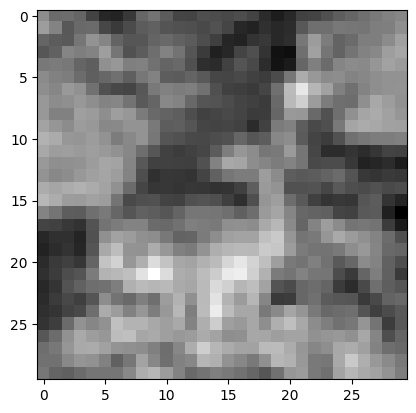

In [22]:
# 그림 그리기
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [23]:
# 출력 이미지가 입력 이미지가 작은 것은 이미지의 경계에서 이뤄지는 작업의 부작용
# 커널을 입력 그림 안에서 미끄러지며 이동하는데 크기가 홀수인 컨볼루션 커널의 길이의 절반만큼 양쪽의 그림이 짤림
# 파이토치는 이미지의 경계에 값이 0인 가짜 픽셀을 패딩하는 기능 제공

In [24]:
# kernel_size=3일 때 padding=1로 지정하면 i00지점에서 왼쪽과 위쪽에 추가 이웃이 만들어짐
# 이를 이용해 원본 이미지에서 모서리에 해당하는 지점에서도 컨볼루션 출력값 계산 가능
# 따라서 출력이 입력과 동일한 크기를 가짐
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [25]:
# 패딩 사용 여부와 weight, bias 크기는 상관 없음
# 패딩을 통해 컨볼루션과 이미지 크기 변경 문제를 별도로 분리해 기억할 필요 없음
# 이를 통해 컨볼루션 구조 자체에 더 신경쓸 수 있음

In [26]:
# 가중치를 직접 설정하여 컨볼루션에서 일어나는 일 확인
# bias를 0으로 제거해 교란 변수 배제하고 가중치에 상수값을 넣어 출력에서 각 픽셀이 자신의 이웃 픽셀에 대한 평균을 갖게 함
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

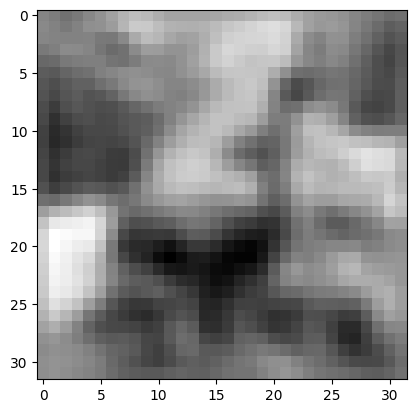

In [27]:
# 각 출력 픽셀은 자신의 주변 픽셀에 대한 평균이기 때문에 픽셀 간의 변화가 부드러워짐 -> 출력 흐릿해짐
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

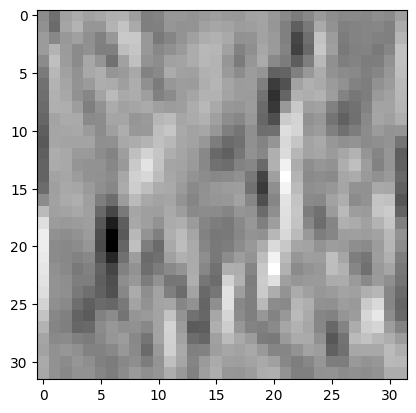

In [28]:
# 커널 수동 변경: 수직 경계 강조
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [29]:
# 이 외에도 수평이나 대각선 경계 혹은 십자 모양이나 체스판 패턴 등을 탐지하는 필터 제작 가능
# 탐지한다는 것은 높은 출력값을 가진다는 것

In [30]:
# 과거에는 전문가의 역할로 필터는 조합하였지만 현재는 딥러닝을 통해 데이터로부터 커널 자동 생성
# 이 관점에서 컨볼루션 신경망의 역할은 멀티 채널 이미지를 다른 멀티 채널 이미지로 변환하는 연속된 계층인 필터 더미 집한인 커널을 추정하는 것이며 각 채널은 피처에 대응함

In [31]:
# 3*3이나 5*5 같은 작은 커널 사용 추천(지역성의 한계)
# 이미지 내 물체가 5 픽셀보다 클 때 신경망이 패턴 인식할 수 있어야 함
# 컨볼루션을 층층이 쌓으면서 연속적인 컨볼루션 사이의 이미지를 다운샘플링하는 방법 존재

In [32]:
# 이미지를 반으로 줄이는 것은 이웃하는 네 개의 픽셀을 입력받아 한 픽셀을 출력하는 작업과 같음
# 평균 풀링(최근에는 잘 사용하지 않음), 맥스 풀링(최근 가장 널리 쓰이지만 데이터의 75% 버림), 스트라이드하며 컨볼루션 수행하되 n번째 픽셀만 계산하기(가능성 보여주는 논문은 있지만 맥스 풀링 대체할 정도 아님)

In [33]:
# 황성 함수로 연결되므로 컨볼루션층의 이미지의 각 값은 특정 커널에 대응하는 패턴이 발견될 때 높은 값을 가짐
# 다운샘플링을 통해 2*2 인접 픽셀에서 최댓값을 뽑는 것은 약한 신호는 버리고 살아남은 피처를 발견하는 과정으로 볼 수 있음

In [34]:
# 맥스 풀링은 nn.MaxPool2d 모듈에 존재
# 입력으로 풀링 연산을 수행할 인접 영역 크기를 받음
# 이미지를 반으로 줄이고 싶다면 크기를 2로 지정
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [35]:
# 컨볼루션과 다운샘플링의 조합이 큰 패턴 식별하는 방법 확인 -> 그림 8.8 참조
# 두 번째 커널셋은 반으로 줄어든 이미지 안에서 3*3의 인접 픽셀에 대해 동작하므로 원래 입력의 8*8 인접 영역에 대해 효과적으로 동작하는 셈
# 두 번째 커널셋은 첫 번째 커널셋의 피처를 받아 추가적인 피처 추출
# 첫 번째 커널셋이 먼저 작은 영역 내에서 1차로 저수준의 피처에 대해 동작하는 한편 두 번째 커널셋은 얻은 피처들을 합성한 피처를 만들고 더 넓은 범위에 대해 효과적으로 동작
# 이런 메커니즘은 CIFAR-10 데이터셋에서 얻은 32*32 이미지보다 더 복잡한 장면을 인식하는 컨볼루션 신경망 제공

In [36]:
# nn.Conv2d와 nn.MaxPool2d로 신경망에 적용
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), # 입력 채널 3(RGB)을 16개의 독립적 피처(16 채널)를 만들어 저수준의 피처 탐색
                      nn.Tanh(),
                      nn.MaxPool2d(2), # 32*32 이미지(16채널) -> 16*16 이미지(16채널)
                      nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16*16 이미지(16채널) -> 16*16(8채널)
                      nn.Tanh(),
                      nn.MaxPool2d(2), # 16*16(8채널) -> 8*8 이미지(8채널)
                      #...
                      )

In [37]:
# 이 신경망은 결국 음의 로그 가능도로 넣을 수 있는 확률값을 뽑아야 함
# 확률은 1차원 벡터인 숫자 쌍으로 나와햐 하는데(하나는 비행기, 나머지는 새)  지금은 멀티 채널의 2차원 피처인 상태
# 8채널의 8*8 이미지를 1차원 벡터로 바꿔서 완전 연결 계층으로 신경망 마무리
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), # 입력 채널 3(RGB)을 16개의 독립적 피처(16 채널)를 만들어 저수준의 피처 탐색
                      nn.Tanh(),
                      nn.MaxPool2d(2), # 32*32 이미지(16채널) -> 16*16 이미지(16채널)
                      nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16*16 이미지(16채널) -> 16*16(8채널)
                      nn.Tanh(),
                      nn.MaxPool2d(2), # 16*16(8채널) -> 8*8 이미지(8채널)
                      #...
                      nn.Linear(8 * 8 * 8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

In [38]:
# 선형 계층의 크기가 MaxPool2d의 출력 크기 8*8*8=512에 의존성을 가지는 점 주목
# 이 모델의 파라미터 수 확인
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [39]:
# 작은 이미지의 제한된 데이터셋을 생각하면 수긍할 만한 편
# 모델의 용량을 높이려면 컨볼루션층의 출력 채널 수를 늘려 연결되는 선형 계층도 키우면 됨
# 위 모델 실행하면 런타임 오류가 남
# model(img.unsqueeze(0))

In [40]:
# 8채널의 8*8 이미지를 512요소를 가진 1차원 벡터로 차원 정보를 변경해야 하는 부분을 넘어감
# 마지막 맥스풀링의 출력에 대해 view를 호출하면 해결할 수 있지만 nn.Sequential 사용할 때는 각 모듈의 출력을 명시적으로 볼 수 없음

## 3절 - nn.Module 서브클래싱하기

In [41]:
# 신경망 개발하다 보면 기존에 만들어진 모듈에서 지원하지 않는 연산 필요한 경우 발생
# nn.Module의 서브클래스를 직접 만들어 이미 만들어진 것이나 nn.Sequential처럼 사용할 수 있게 할 예정

In [42]:
# 계층 뒤에 다른 계층 붙이는 것보다 복잡한 일을 수행하는 모델을 만드려면 유연성을 위해 nn.Sequential 포기
# 파이토치에서는 nn.Module 서브클래싱으로 모델에서 어떤 연산이든 수행 가능하게 함

In [43]:
# nn.Module 서브클래싱하라면 먼저 forward 함수 정의하여 모듈로 입력을 전달하고 출력을 반환하게 해야 함 -> 모듈의 연산을 정의하는 영역
# 파이토치에서는 표준 torch 연산을 사용하기만 하면 자동미분 기능이 자동으로 역방향 경로를 만드므로 nn.Module에는 backward 필요 없음

In [44]:
# 지금 만들 연산도 결국 이미 있는 모듈이나 커스텀 모듈 사용
# 서브모듈을 포함하려면 생성자 __init__에 정의하고 self에 할당해 forward 함수에서 사용할 수 있게 만들어야 함
# 모듈이 동작하는 동안 파라미터가 유지될 것
# 모든 코드에 앞서 super().__init__() 호출해야 함

In [45]:
# 앞서 nn.Sequential에 먼겼던 모든 것을 생성자에 넣고 이 인스턴스들을 forward에서 순서대로 사용
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # 샘플이 얼마나 들어올 지 모르므로 배치 차원을 -1로 설정
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
# Net 클래스는 앞서 만든 nn.Sequential 모델과 같은 서브모듈이지만 명시적으로 forward 함수를 작성했기에 self.pool3의 출력을 직접 조작해서 view를 통해 B*N 벡터로 만들 수 있음
# nn.Module의 서브클래스는 모델 전체를 담는 데 활용
# 더 복잡한 신경망을 위한 새로운 빌딩 블럭을 정의하기 위해 Net 서브클래스 사용 가능

In [47]:
# 분류 신경망의 목적은 일반적으로 큰 수의 픽셀을 가진 이미지에서 출발해 정보를 압축해가면서 분류 클래스(의 확률 벡터)로 만드는 것
# 이 목적에 따라 두 가지 설명할 점

In [48]:
# 1. 중간에 나타나는 값의 개수가 점점 줄어드는 모습에 우리가 목표하는 바가 반영됨
#    컨볼루션의 채널 수가 줄어들고 풀링에서 픽셀 수 줄어들며 선형 계층에서는 입력 차원보다 낮은 수의 차원을 출력 -> 분류 신경망의 전형적 특징
#    하지만 Resnet 같은 인기 있는 모델 같은 경우, 풀링 시 공간 분해능(spatial resolution)감소가 있더라도 채널 수 늘어남(전체 사이즈는 결과적으로 감소)
#    빠르게 정보를 축소하는 패턴은 제한된 깊이의 신경망과 작은 이미지에 대해서는 잘 동작하지만 신경망이 깊어질수록 감소는 천천히 일어남

In [49]:
# 2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않음
#    출력 픽셀 하나를 32개 요소(채널)를 가진 벡터로 보면 27개 요소(3채널*3*3 커널 크기 가지는 컨볼루션)를 가지는 선형 변환에 해당하며 어느 정도 증가하는 셈
#    레즈넷에서 초기 컨볼루션은 147(3채널*7*7 커널 크기)개의 요소로부터 64개 채널 만듦
#    이 때문에 첫 계층은 예외적으로 통과하는 데이터의 전체 차원을 크게 증가시킴(채널에 픽셀을 곱한 정도로)
#    하지만 출력된 픽셀을 개별적으로 생각해보면 대략 입력만큼의 출력을 가진다고 생각할 수 있음

In [50]:
# 위 코드에서 생성자 엔에서 nn.Module의 속성에 nn.Module의 인스턴스 할당하여 모듈을 서브모듈로 등록함
# nn.Module 서브클래서의 메소드라면 언제나 호출 가능
# 예를 들어 훈련과정이 실제 사용(예측) 때와 매우 다른 경우 별도로 predict 메소드를 만드는게 나을 수 있음
# 이러한 메소드의 호출은 모듈 자체보다는 forward 메소드 호출하는 것과 비슷하여 hook 호출을 놓치게 되고 __call__을 호출하지 않기 때문에 JIT는 사용시 모듈 구조를 볼 수 없음

In [51]:
# 아래와 같이 사용자의 추가 행위 없이 서브모듈의 파라미터에 접근할 수 있게 됨
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [52]:
# 코드의 parameters() 호출은 생성자에서 속성으로 할당된 모든 서브모듈을 찾아 이들의 parameters()를 재귀적으로 호출함
# 얼마나 중첩되어 있든 모든 자식 파라미터의 리스트에 접근 가능

In [53]:
# Net 클래스 구현에서 파라미터가 없는 nn.Tanh나 nn.MaxPool2d 같은 서브 모듈은 등록하지 않고 forward 함수에서 직접 호출하는게 나을 것으로 보임
# 파이토치는 모든 nn 모듈에 대한 함수형을 제공
# 함수형은 내부 상태가 없다는 의미 -> 출력값이 전적으로 입력 인자에 의존
# torch.nn.functional은 nn 모듈과 동일한 함수를 제공하지만 호출시 인자로 입력값 외에 파라미터도 받음

In [54]:
# 파라미터 없는 서브 모듈 함수형으로 적용
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
# 함수적인 방식으로 말미암아 nn.Module API란 Parameter라는 모습으로 상태를 저장하고 순방향 전달에 필요한 명령 집합을 서브모듈로 저장하는 컨테이너로 정의 가능

In [56]:
# 함수형과 모듈 API 활용할지는 각자의 취향 문제
# 신경망이 매우 단순하여 nn.Sequential 쓰고 싶어지면 모듈이 답이고, 직접 순방향 흐름을 작성하는 경우라면 파라미터로 상태를 저장할 필요 없는 함수형 인터페이스가 정답

In [57]:
# 사용하다 보면 예상치 못한 동작을 보일 때가 있으니 주의히야 함
# nn.HardTanh나 nn.ReLU처럼 상태 없는 모듈이 여러 애플리케이션에서 필요한 경우 각각을 별도의 인스턴스로 두는 것이 좋음
# 같은 모듈 인스턴스를 재사용하면 표준 파이토치 용법에서는 정확한 결과를 보여줘도 모델 분석하는 도구에서 문제 일으킬 수 있음

In [58]:
# 모델이 동작하는지 점검
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0799, -0.0387]], grad_fn=<AddmmBackward0>)

## 4절 - 우리가 만든 컨볼루션 신경망 훈련시키기

In [59]:
# 정확도 추적을 위해 약간의 수정을 추가한 후 빠르게 학습하기 위해 GPU에서 고속으로 돌리는 법 확인

In [60]:
# 우리의 컨볼루션 신경망은 에포크 단위로 도는 바깥 루프와 Dataset에서 배치를 만드는 DataLoader 단위로 도는 안쪽 루프 존재

In [61]:
# 각 루프에서
# 1. 모델에 입력값 넣기(순방향 전달)
# 2. 손실값 계산(순방향 전달)
# 3. 이전 기울기값 0으로 리셋
# 4. loss.backward() 호출하여 모든 파라미터에 대해 손실값의 기울기 계산(역방향 전달)
# 5. 옵티마이저를 통해 손실값을 낮추도록 파라미터 조정

In [62]:
# 훈련 루프 확인
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): # epoch는 1부터 n_epoch까지로 부여
        loss_train = 0.0

        for imgs, labels in train_loader: # 데이터 로더가 만든 배치 안에서 데이터셋 순회
            outputs = model(imgs) # 모델에 배치 넣기
            loss = loss_fn(outputs, labels) # 최소화하려는 손실값 계산

            optimizer.zero_grad() # 마지막에 이전 기울기 값 리셋
            loss.backward() # 역전파 수행, 신경망이 모든 파라미터에 대한 기울기 계산
            optimizer.step() # 모델 업데이트

            loss_train += loss.item() # 에포크 동안 확인한 손실값 모두 더하기(기울기값 꺼내기 위해 item()을 사용해 손실값을 파이썬 수로 변환하는 부분 중요)

        if epoch == 1 or epoch % 10 == 0: # 배치 단위의 평균 손실값을 구하기 위해 훈련 데이터 로더의 길이로 나눔(총합보다 직관적임)
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [63]:
# 7장과는 다르게 커스텀 nn.Module 서브클래스를 통해 컨볼루션을 사용함
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) # DataLoader로 cifar2 데이터셋 예제를 배치로 묶기

model = Net() # 신경망 초기화
optimizer = optim.SGD(model.parameters(), lr=1e-2) # 확률적 경사 하강 옵티마이저
loss_fn = nn.CrossEntropyLoss() # 크로스엔트로피 손실값

training_loop(n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader)

2024-02-06 01:10:33.083035 Epoch 1, Training loss 0.5600486796373015
2024-02-06 01:11:02.843432 Epoch 10, Training loss 0.3320057189008992
2024-02-06 01:11:46.146654 Epoch 20, Training loss 0.2960086602504086
2024-02-06 01:12:25.976992 Epoch 30, Training loss 0.2679507405894577
2024-02-06 01:13:01.953244 Epoch 40, Training loss 0.24457929387783547
2024-02-06 01:13:37.786315 Epoch 50, Training loss 0.22398669680782185
2024-02-06 01:14:15.741641 Epoch 60, Training loss 0.20715277020338993
2024-02-06 01:14:53.924375 Epoch 70, Training loss 0.19392345017593376
2024-02-06 01:15:31.269123 Epoch 80, Training loss 0.17986100541937883
2024-02-06 01:16:12.418507 Epoch 90, Training loss 0.16647940586991372
2024-02-06 01:16:46.661624 Epoch 100, Training loss 0.1542861446928067


In [64]:
# 손실값보다 해석하기 좋은 측정 방법으로 훈련셋과 검증셋을 통한 정확도 측정
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad(): # 파라미터 업데이트 안 하므로 기울기 필요 없음
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 가장 높은 값 가진 인덱스 출력
                total += labels.shape[0] # 예제 수 세어 total을 배치 크기만큼 증가
                correct += int((predicted == labels).sum()) # 확률값이 가장 높은 클래스와 레이블의 실측값 비교하여 불리언 배열을 얻고, 예측값이 실측값에 맞은 경우가 배치에서 얼마나 나왔는지 세어 합산

        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.94


In [65]:
# 더 적은 파라미터를 사용하여 완전 연결 모델보다 성능 좋아진 것을 확인 가능
# 이미지에 있는 물체를 인식하는 작업이 지역성이나 평행이동 불변성에 대응하여 더 일반화 됨

In [66]:
# 파일로 모델 저장
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt') # birds_vs_airplanes.pt파일에 model의 모든 파라미터 들어감

In [67]:
# 두 개의 컨볼루션 모듈과 두 개의 선형모델에 포함된 가중치와 편향값을 저장하고 있으며, 모델 구조는 포함 안됨
# 모델을 실제 서비스 목적으로 제공한다면 model 클래스도 보관해뒀다가 인스턴스를 만들고 파라미터를 파일에서 읽어와야 함
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [68]:
# .to 메소드 사용하여 데이터 로더에서 얻은 텐서를 GPU로 옮길 수 있음
# 파라미터 또한 GPU로 옮길 필요가 있음
# nn.Module에 .to 메소드 있어서 모든 파라미터를 GPU로 옮길 수 있음(혹은 dtype 인자 전달할 때 타입 변경할 수 있음)

In [69]:
# Module.to는 모듈 인스턴스 자체를 수정하지만 Tensor.to는 새 텐서를 반환함
# 파라미터를 원하는 디바이스로 이동 후 Optimizer를 만드는 식의 구현을 추천

In [70]:
# GPU로 옮겨 작업하는 방식도 추천함
# torch.cuda.is_available 값에 따라 device 변수 설정하는 것이 좋은 구현 패턴
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [71]:
# Tensor.to 메소드로 데이터 로더가 올려준 텐서를 GPU로 옮기도록 훈련 루프 수정
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) # imgs텐서 GPU로 이동
            labels = labels.to(device=device) # labels텐서 GPU로 이동
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [72]:
# 모델을 인스턴스화하고 device로 옮긴 후 이전처럼 실행
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device) # 모델(파라미터)를 GPU로 이동. 모델이나 입력을 GPU로 옮기지 않으면 파이토치는 GPU와 CPU 입력을 섞어 실행하는 연산 지원하지 않아 에러 발생
optimizer = optim.SGD(model.parameters(), lr=1e-2) # 확률적 경사 하강 옵티마이저
loss_fn = nn.CrossEntropyLoss() # 크로스엔트로피 손실값

training_loop(n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader)

2024-02-06 01:16:53.280477 Epoch 1, Training loss 0.5574434280015861
2024-02-06 01:16:56.275853 Epoch 10, Training loss 0.3326021065567709
2024-02-06 01:17:00.147881 Epoch 20, Training loss 0.2967864487581192
2024-02-06 01:17:04.691421 Epoch 30, Training loss 0.2724945445539086
2024-02-06 01:17:08.854255 Epoch 40, Training loss 0.24483573237422165
2024-02-06 01:17:13.893695 Epoch 50, Training loss 0.2295034944441668
2024-02-06 01:17:17.772714 Epoch 60, Training loss 0.2100594720927773
2024-02-06 01:17:21.862711 Epoch 70, Training loss 0.1959396865171422
2024-02-06 01:17:25.354851 Epoch 80, Training loss 0.18157079246393434
2024-02-06 01:17:28.715631 Epoch 90, Training loss 0.16782244869098542
2024-02-06 01:17:32.634177 Epoch 100, Training loss 0.1551272368212794


In [73]:
# validate 함수도 동일한 방식으로 수정 필요
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)
validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.93
Accuracy train: 0.93
Accuracy val: 0.93


{'train': 0.9276, 'val': 0.9276}

In [74]:
# 가중치 읽어올 때의 문제점
# 파이토치는 가중치를 저장할 때 어떤 디바이스를 기억했다가 반대로 읽어들일 때도 해당 디바이스를 사용하므로 GPU에 있던 가중치는 GPU로 복구됨
# 나중에 어떤 디바이스에서 돌릴지 모르므로 신경망을 CPU로 옮긴 후에 저장하거나 파일에서 읽어들인 후 CPU로 옮겨야 함
# 가중치를 로딩할 때 파이토치가 기억하는 디바이스 정보를 덮어쓰면 해결됨

In [75]:
# torch.load 인자에 map_location 키워드 전달
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## 5절 - 모델 설계

In [76]:
# 이미지넷처럼 더 크고 복잡한 이미지에서 답을 찾으려면 여러 시각적 단서를 찾기 위해 계층적인 구조화가 필요

In [77]:
# 신경망은 적절한 아키텍처와 적절한 손실 함수가 주어질 경우 이런 종류의 데이터를 대상으로 문제를 풀만큼 충분히 유연함

In [78]:
# 파이토치는 매우 다양한 모듈과 손실 함수를 담아 제공되므로 단순한 피드포워드 요소부터 장단기 메모리(LSTM, long short-term memory) 모듈과 트랜스포머 신경망(유명한 시계열 데이터를 위한 아키텍처 두 가지) 구현 가능

In [79]:
# 피드포워드 아키텍처 하나 소개
# 차원 정보 몇 가지 확인
# 첫 번째는 신경망의 너비(width) 차원: 신경망 계층 내의 뉴런 수 혹은 컨볼루션의 채널 수에 해당하는 값
# 첫 컨볼루션의 출력 채널 수를 더 크게 하고 이어지는 계층도 여기에 맞춰 키우면 더 길어진 벡터를 가지므로 완전 연결 계층으로 전환되는 forward 함수에도 반영됨
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [80]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2024-02-06 01:17:34.659221 Epoch 1, Training loss 0.5476510027411637
2024-02-06 01:17:38.281891 Epoch 10, Training loss 0.3159592417395039
2024-02-06 01:17:42.379528 Epoch 20, Training loss 0.27935424371130146
2024-02-06 01:17:46.626721 Epoch 30, Training loss 0.25037075398833886
2024-02-06 01:17:50.717640 Epoch 40, Training loss 0.22370669706042406
2024-02-06 01:17:54.949877 Epoch 50, Training loss 0.19702736592027031
2024-02-06 01:17:59.260092 Epoch 60, Training loss 0.17191327092753853
2024-02-06 01:18:03.269391 Epoch 70, Training loss 0.14846387510276904
2024-02-06 01:18:08.097280 Epoch 80, Training loss 0.12653389307344035
2024-02-06 01:18:11.942967 Epoch 90, Training loss 0.10615980805485112
2024-02-06 01:18:16.823301 Epoch 100, Training loss 0.0878197591704358
Accuracy train: 0.97
Accuracy val: 0.97


{'train': 0.9687, 'val': 0.9687}

In [81]:
# 모델 정의에서 하드코딩을 피하기 위해 파라미터를 init에 전달하고 너비를 파라미터화해서 forward 함수에서 view를 호출할 때도 이를 고려
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [82]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2024-02-06 01:18:18.223207 Epoch 1, Training loss 0.5469720543949468
2024-02-06 01:18:24.388362 Epoch 10, Training loss 0.32020431424781776
2024-02-06 01:18:29.261317 Epoch 20, Training loss 0.28160169910473426
2024-02-06 01:18:32.856660 Epoch 30, Training loss 0.24710290983414193
2024-02-06 01:18:38.649868 Epoch 40, Training loss 0.21629857139033118
2024-02-06 01:18:44.174388 Epoch 50, Training loss 0.1903127281434217
2024-02-06 01:18:48.116832 Epoch 60, Training loss 0.16720800557333954
2024-02-06 01:18:52.036309 Epoch 70, Training loss 0.14560377220534215
2024-02-06 01:18:56.195759 Epoch 80, Training loss 0.1248191498741982
2024-02-06 01:19:02.893084 Epoch 90, Training loss 0.10505882155885742
2024-02-06 01:19:07.585517 Epoch 100, Training loss 0.08670858388683599
Accuracy train: 0.96
Accuracy val: 0.96


In [83]:
# 각 계층에서 채널과 피처의 수를 나타내는 숫자들은 직접적으로 모델의 파라미터 수에 영향을 미침
# 다른 부분이 동일한 경우 이런 변화는 모델의 용량을 증가시킴
# 모델이 가진 파라미터의 갯수 확인
sum(p.numel() for p in model.parameters())

38386

In [84]:
# 용량 클수록 모델이 다룰 수 있는 입력은 다양해지지만 과적합할 가능성도 증가함
# 과적합을 제어하기 위해 모델 레벨에서 다룰 수 있는 대표적인 트릭 확인

In [85]:
# 훈련셋에 대해 손실값을 줄이는 경우인 최적화 단계, 모델이 훈련셋뿐 아니라 이전에 겪어보지 않은 데이터에 대해서도 동작하게 하는 일반화 단계가 있음
# 이 두 단계를 위한 수학적 도구를 모아 정규화(regularization)라고 함

In [86]:
# 일반화(generalization)를 안정적으로 수행하기 위한 방법
# 1. 손실값에 정규화 항을 넣는 것

In [87]:
# 이 정규화 항을 조작해 모델의 가중치가 상대적으로 작게 만듦 -> 훈련을 통해 증가할 수 있는 크기 제한
# 손실 값은 다소 매끄러운 등고선 형태를 띠는데 개별 샘플에 맞춰서 얻는 이득이 상대적으로 줄어듦
# 가장 유명한 정규화 항으로 L2 정규화와 L1 정규화 존재
# L2 정규화는 모델의 모든 가중치에 대한 제곱합, L1 정규화는 모델의 모든 가중치 절대값의 합: 둘 다 훈련 전에 설정하는 하이퍼파라미터의 값으로 범위를 조정함

In [88]:
# L2 정규화는 가중치 감쇠(weight decay)라고도 함
# 가중치 감쇠는 편향값 같은 신경망의 모든 파라미터에 적용됨

In [89]:
# 파이토치에서 손실값 계산 후 모델의 각 파라미터를 돌면서 제곱이나 절댓값을 더하고 역전파하여 L2 혹은 L1 구현
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() # l1 정규화면 pow(2.0) 대신 abs() 사용
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss_fn.backward()
            optimizer.step()

            loss_train += loss.item()

            if epoch % 10 == 0:
                print('{} epoch {}, training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [90]:
# 파이토치의 SGD 옵티마이저에는 이미 weight_decay 파라미터가 있고 2*lambda 값을 가지며 업데이트 동작시 앞에서 설명한 것처럼 가중치 감쇠를 수행함
# 손실값에 가중치의 L2 정규화를 더한 것과 동일하므로 자동미분과 손실값에서 항을 누적하는 작업할 필요 없음

In [91]:
# 일반화(generalization)를 안정적으로 수행하기 위한 방법
# 2. 입력 하나에 너무 의존하지 않기: 드랍아웃

In [92]:
# 훈련을 반복할 때마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는 작업
# 매 훈련마다 조금씩 다른 뉴런의 토폴로지가 만들어지기 때문에 신경망이 각 입력 샘플 암기하는 기회를 줄여 과적합을 방지함
# 모델이 피처를 만들려는 것을 교한하여 데이터 증강과 비슷한 효과를 내지만, 증강과 다르게 신경망 전체에 이런 효과를 냄

In [93]:
# 파이토치에서는 모듈 사이에 nn.Dropout 모듈 넣어 구현 가능
# 인자는 어떤 입력이 0이 될지에 대한 확률 지정
# 컨볼루션은 전용 값인 nn.Dropout2d나 nn.Dropout3d로 해당 입력값의 채널 전부를 0으로 만듦
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [94]:
# 드랍아웃은 훈련 중에 활성화되고 훈련이 끝난 모델을 제품으로 사용할 때는 그냥 통과하게 두거나 확률값을 0으로 함
# Dropout 모듈의 train 프로퍼티를 통해 제어하면 됨
# 파이토치는 model.train()혹은 model.eval() 호출로 전환 가능
# 이 호출은 서브 모듈에도 자동으로 적용되므로 그 중 Dropout 있다면 순방향 혹은 역방향 전달시 원하는 대로 모드가 전환되어 동작할 것임

In [99]:
# 일반화(generalization)를 안정적으로 수행하기 위한 방법
# 3. 활성 함수 억제하기: 배치 정규화

In [94]:
# 논문 <배치 정규화: 내부 공변량 이동을 줄여 딥러닝 훈련을 가속하기>
# 학습률 높이면서 훈련은 초기화에 영향을 덜 받고 정규화처럼 동적하여 드랍아웃에 대한 대체 방법 설명

In [95]:
# 배치 정규화(batch normalization)의 핵심: 입력 범위를 신경망의 활성 함수로 바꿔 미니 배치가 원하는 분포를 가지게 하는 것
# 배치 정규화는 미니배치 샘플을 통해 중간 위치에서 얻은 평균과 표준편차를 사용하여 중간 입력값을 이동하고 범위를 변경시킴
# 따라서 모델이 보는 개별 샘플이나 이로 인한 이후의 활성화 단계에서는 랜덤하게 뽑아 만들어진 미니배치에서 통계에 의존한 값의 이동과 범위 조정이 반영됨 -> 원칙적인 데이터 증강
# 저자진은 배치 정규화가 드랍아웃의 필요성을 줄이거나 없앤다고 주장함

In [96]:
# 파이토치는 nn.BatchNorm1D,2D,3D 모듈로 배치 정규화를 지원함
# 활성 함수의 입력 범위를 조정하는 것이 목적이므로 선형 변환의 뒤에 위치함
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [97]:
# 평가 시에 출력은 모델이 이미 봤던 다른 입력의 통계에 의존하는 특정 입력을 위한 것이 되어서는 안되므로 훈련과 평가 때 다르게 동작해야 함

In [98]:
# 미니배치가 실행되면 현재의 미니배치에 대한 평균과 표준편차를 구하는 것과 더불어 파이토치가 전체 데이터셋에 대한 평균과 표준편차도 대략적으로 업데이트 함
# 사용자는 model.eval()을 명시하고, 모델이 배치 정규화 모듈을 가지는 경우 추정값을 고정하고 정규화에 사용하기만 함
# 추정을 해제하고 미니 배치 통계를 추정해가길 원하면 model.train()을 호출함

In [100]:
# 모델이 깊어질 수록 신경망은 더 복잡한 함수에 근사 가능
# 맥락을 이해할 수 있게 하려면 모델을 깊게 만들어 계층적인 정보를 다룰 수 있게 해야 함
# 다른 관점으로 '깊이를 더한다'는 것은 신경망이 입력을 처리할 때 수행할 연산을 더 길게 나열할 수 있다는 것

In [101]:
# 모델에 깊이가 더해질수록 훈련은 수렴하기 어려워짐
# 곱셈이 체인이 길게 이어지는 경우 기울기값에 기여하는 파라미터가 사라져(vanishing) 파라미터 같은 값들이 적절히 업데이트 되지 않아 효과 없는 훈련 초래

In [103]:
# 카이밍 히와 공저자들이 단순한 트릭으로 깊은 신경망도 성공적으로 훈련시키는 잔차 신경망(residual network)인 ResNet 개발
# 계층의 짧은 회로 블럭에 스킵 커넥션(skip connection) 사용하는 기법
# 입력을 계층 블럭의 출력에 연결하는 것으로 파이토치에서 수행 가능

In [104]:
# 컨볼루션 모델에 계층 하나 추가하고 변화를 위한 활성 함수로 ReLU 사용
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [105]:
# 첫 번째 계층의 출력을 세 번째 계층의 입력에 추가하는 스킵 커넥션 추가
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [106]:
# 바꿔 말하면 표준 피드포워드 경로에 추가적으로 첫 번째 활성 함수의 출력을 마지막 부분의 입력으로 사용하는 것
# 아이덴티티 매핑(identity mapping)이라고도 부름

In [107]:
# 경사 소실(vanishing gradient) 문제 해결하는 이유
# 스킵 커넥션 혹은 심층 신경망에서의 연속적인 스킵 커넥션은 깊은 쪽에 있는 파라미터를 손실값에 연결하는 역할
# 체인으로 길게 연결된 다른 연산들로 곱해질 기회가 줄어들고 파라미터에 대한 손실값의 편미분으로 손실값에 대한 기울기에 더욱 직접적으로 관여
# 특히 훈련의 초반 단계에서 수렴에 도움이 되는 방향으로 작용하는 것이 확인됨
# 잔차 신경마으이 손실값 분포는 동일한 깊이나 너비를 가진 피드포워드 신경망보다 훨씬 부드러움

In [108]:
# 일반적으로 100개 이상의 계층을 담을 때 (Conv2d, ReLU, Conv2d) + skip connection 같은 빌딩 블럭 정의 후 for 사용하여 신경망을 동적으로 만듦

In [109]:
# 컨볼루션, 활성 함수, 스킵 커넥션으로 이뤄진 블럭을 위한 연산을 제공하는 모듈 서브클래스 정의
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) # BatchNorm 계층은 편향값의 효과를 상쇄하므로 관례상 생략
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') # 커스텀 초기화. kaiming_normal_은 표준편차를 가지는 표준 랜덤 요소로 초기화시킴.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5) # 배치 정규화는 기본값으로 평균 0과 분산 0.5를 가지는 분포의 출력 만들도록 초기화
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [110]:
# init에서 ResBlock 인스턴스 리스트를 포함한 nn.Sequential 만들고 forward에서 호출해 100개 블럭 거쳐 출력
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [111]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2024-02-06 02:36:12.738531 Epoch 1, Training loss 1.1183038353919983
2024-02-06 02:37:46.403515 Epoch 10, Training loss 0.41658011724235144
2024-02-06 02:39:32.431704 Epoch 20, Training loss 0.3324292610595181
2024-02-06 02:41:17.190848 Epoch 30, Training loss 0.2599465257612763
2024-02-06 02:43:08.757661 Epoch 40, Training loss 0.2304621884112905
2024-02-06 02:44:55.187560 Epoch 50, Training loss 0.152899604812739
2024-02-06 02:46:48.003193 Epoch 60, Training loss 0.12591910611387272
2024-02-06 02:48:37.472839 Epoch 70, Training loss 0.10866580801499877
2024-02-06 02:50:27.949616 Epoch 80, Training loss 0.09665038500716731
2024-02-06 02:52:30.053130 Epoch 90, Training loss 0.08555212021348582
2024-02-06 02:54:19.879375 Epoch 100, Training loss 0.10712052772569049
Accuracy train: 0.98
Accuracy val: 0.98


In [112]:
# 초기화는 신경망 훈련의 중요한 방법 중 하나
# 파이토치의 기본 가중치 초기화는 완벽하지 않음
# 개선 전까지는 직접 가중치 초기화 고쳐야 함
# 위 모델은 수렴하지 않았고 일반적인 초기화 방법(가중치 변화량 감소, 배치 정규화)도 사용하였음

In [113]:
# 모델 성능 비교
# 실제로는 좋은 결과를 만들기 위해 부가적인 설계 요소도 추가해야 함

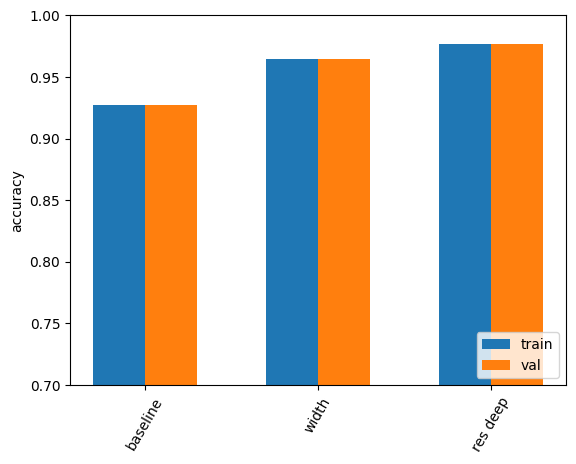

In [118]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# 품질적 측면으로는 검증과 과적합을 다룰 때처럼 순서가 있다고 볼 수 있음
# 정규화 관점에서 배치 정규화보다 훨씬 엄격한 통계적 평가를 수행하는 가중치 감쇠와 드랍아웃 정규화는 정확도 간의 차이가 훨씬 작음
# 배치 정규화는 모델의 수렴을 돕는 역할로 신경망은 거의 100%의 훈련 정확도 가짐
# 그래서 반대로 가중치 감쇠와 드랍아웃은 정규화로 해석함

## 6절 - 결론

In [114]:
# 더 큰 이미지로부터 새와 비행기 구별하는 문제나 고양이를 새 혹은 비행기로 추정해버리는 과잉 일반화(overgeneralizaion) 문제 해결해야 함 -> 입력을 신뢰할 수 없는 경우
# 괜찮은 수준의 모델을 만들어 이미지로 학습시킴
# 컨볼루션 신경망에 대한 직관적인 이해 넓힘
# 더 큰 실세계의 문제에 도전할 것임

## 7절 - 연습 문제

In [115]:
# 1. 지금까지 다룬 모델을 nn.Conv2d 생성자에 kernel_size=5를 넣어 5*5 커널을 사용하도록 바꾸자
#    a. 이렇게 바꾼 경우 모델의 파라미터 수는 어떻게 바뀌는가? (75810, [864, 32, 9216, 32, 32, 65536, 32, 64, 2]) -> (92194, [864, 32, 25600, 32, 32, 65536, 32, 64, 2])
#    b. 바꾼 후에 과적합은 개선되는가 혹은 나빠지는가? 기존 결과가 너무 좋아 판단하기 어려움 "Accuracy train: 0.98 Accuracy val: 0.98" -> "Accuracy train: 1.00 Accuracy val: 1.00"
#    c. https://pytorch.org/docs/stable/nn.html#conv2d를 읽어보라. O
#    d. kernel_size=(1, 3)을 설명할 수 있는가? 1행3열짜리 커널을 사용한다는 뜻
#    e. 이런 커널을 사용하면 모델은 어떻게 동작하는가? 기존의 주변 픽셀들과의 연관성을 나타내던 정사각형 커널과 다르게 양 옆의 픽셀들과의 연관성을 의미하는 출력값 나오도록 동작함

In [128]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=5, padding=2, bias=False) # kernel_size 증가로 인한 padding값 증가(size 안 맞음)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x


class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [129]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(92194, [864, 32, 25600, 32, 32, 65536, 32, 64, 2])

In [135]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2024-02-06 03:57:33.991890 Epoch 1, Training loss 0.253474532134214
2024-02-06 03:59:04.508599 Epoch 10, Training loss 0.21231732365621883
2024-02-06 04:01:08.934173 Epoch 20, Training loss 0.18062220288404993
2024-02-06 04:02:52.385677 Epoch 30, Training loss 0.15554644599272188
2024-02-06 04:04:31.608819 Epoch 40, Training loss 0.12812381690949393
2024-02-06 04:06:10.181610 Epoch 50, Training loss 0.11350509018939771
2024-02-06 04:07:49.110593 Epoch 60, Training loss 0.10402740124067303
2024-02-06 04:09:27.740171 Epoch 70, Training loss 0.08850543893826236
2024-02-06 04:11:06.072726 Epoch 80, Training loss 0.06845422816361971
2024-02-06 04:12:44.337918 Epoch 90, Training loss 0.060921409288955154
2024-02-06 04:14:22.466122 Epoch 100, Training loss 0.05515579685826851
Accuracy train: 0.95
Accuracy val: 0.95


In [116]:
# 2. 새도 비행기도 아니지만 둘 중 하나라고 95% 신뢰도로 판단하게 되는 이미지를 찾을 수 있는가? 실패
#    a. 이런 이미지를 비행기처럼 보이게 편집할 수 있는가?
#    b. 비행기 이미지를 편집해서 모델이 새라고 착각하게 만들 수 있는가?
#    c. 이런 일들은 신경망 용량이 클 때 쉬워지는가 아니면 작을 때 쉬워지는가?

In [155]:
exam_img, exam_label = cifar2[0]
exam_img = exam_img.to(device=device)
exam_label = exam_label
out = model(exam_img.unsqueeze(0))
out

tensor([[ 1.4515, -5.3444]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [175]:
import imageio

img = imageio.imread('../cat.png')
print(img)
exam_img = torch.from_numpy(img)
exam_img = exam_img.to(torch.float)
exam_img = exam_img.permute(2, 0, 1)
exam_img = exam_img.to(device=device)
print(exam_img.unsqueeze(0).shape)
out = model(exam_img.unsqueeze(0))
loss_fn(out, torch.tensor([exam_label]))

[[[  5 102 205]
  [  5 102 205]
  [  5 102 205]
  ...
  [  2  99 202]
  [  2  99 202]
  [  2  99 202]]

 [[  5 102 205]
  [  5 102 205]
  [  5 102 205]
  ...
  [  2  99 202]
  [  2  99 202]
  [  2  99 202]]

 [[  5 102 205]
  [  5 102 205]
  [  5 102 205]
  ...
  [  2  99 202]
  [  2  99 202]
  [  2  99 202]]

 ...

 [[  0  45 146]
  [  0  45 146]
  [  0  45 146]
  ...
  [  2  61 161]
  [  0  62 161]
  [  0  62 161]]

 [[  0  44 145]
  [  0  44 145]
  [  0  44 145]
  ...
  [  1  60 160]
  [  0  61 160]
  [  0  61 160]]

 [[  0  43 145]
  [  0  43 145]
  [  0  43 145]
  ...
  [  1  60 160]
  [  0  61 160]
  [  0  61 160]]]
torch.Size([1, 3, 183, 275])


<ipython-input-175-e9e2eb74f72d>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../cat.png')


RuntimeError: shape '[-1, 2048]' is invalid for input of size 97920